In [1]:
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline

# Input data files are available in the read-only "../input/" directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

warnings.filterwarnings('ignore')

In [6]:
df_dir = "/content/Churn_Modelling.csv"

In [7]:
df = pd.read_csv(df_dir)

In [8]:
print("Training data shape:", df.shape)

Training data shape: (10000, 14)


In [9]:
print("Dataset Info:")
print(df.info())
print("--" * 20)
print("First Few Rows:")
df.head()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None
----------------------------------------
First Few Rows:


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [10]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [11]:
def visualize_categorial_distributions(df):
    # Identify categorical columns
    categorical_columns = df.select_dtypes(include=['object']).columns

    # Set up the figure for multiple subplits
    num_cols = 3
    num_rows = (len(categorical_columns) + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    fig.suptitle("Distribution of Categorical Features", fontsize=16)

    # Flatten axes array for easy iteration
    axes = axes.flatten()

    # Iterate over each categorical column and create a bar plot
    for i, col in enumerate(categorical_columns):
        sns.barplot(
        x=df[col].value_counts().index,
        y=df[col].value_counts().values,
        ax=axes[i],
        palette='viridis'
        )
        # setting titles and labels
        axes[i].set_title(f"Distribution of {col}", fontsize=14)
        axes[i].set_xlabel(col, fontsize=12)
        axes[i].set_ylabel("count", fontsize=12)
        axes[i].tick_params(axis='x')

    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

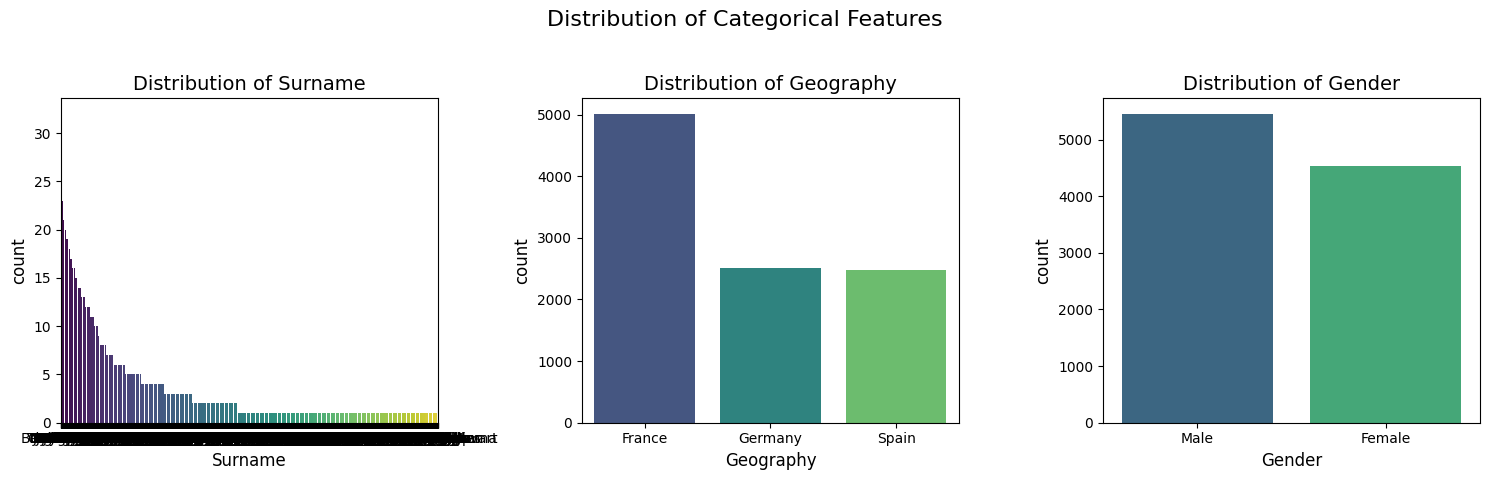

In [12]:
visualize_categorial_distributions(df)

In [13]:
def visualize_numerical_distributions(df, exclude_columns=['RowNumber', 'CustomerId', "Exited"]):
    """
    Visualizes the distribution of numerical features in the DataFrame using histograms and KDE plots,
    excluding specified columns.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the numerical features to visualize.
    - exclude_columns (list): List of column names to exclude from visualization.

    Returns:
    - None: Displays the plots.
    """
    # Ensure exclude_columns is a list
    if exclude_columns is None:
        exclude_columns = []

    # Identify numerical columns and exclude specified ones
    numerical_columns = df.select_dtypes(include=['number']).columns
    numerical_columns = [col for col in numerical_columns if col not in exclude_columns]

    # Set up the figure for multiple subplots
    num_cols = 3  # Number of columns for the subplot grid
    num_rows = (len(numerical_columns) + num_cols - 1) // num_cols  # Calculate number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))
    fig.suptitle('Distribution of Numerical Features', fontsize=16)

    # Flatten axes array for easy iteration
    axes = axes.flatten()

    # Iterate over each numerical column and create a histogram with KDE
    for i, col in enumerate(numerical_columns):
        sns.histplot(df[col], kde=True, ax=axes[i], color="skyblue", element="step", stat="density")
        axes[i].set_title(f'Distribution of {col}', fontsize=14)
        axes[i].set_xlabel(col, fontsize=12)
        axes[i].set_ylabel('Density', fontsize=12)

    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the main title space
    plt.show()

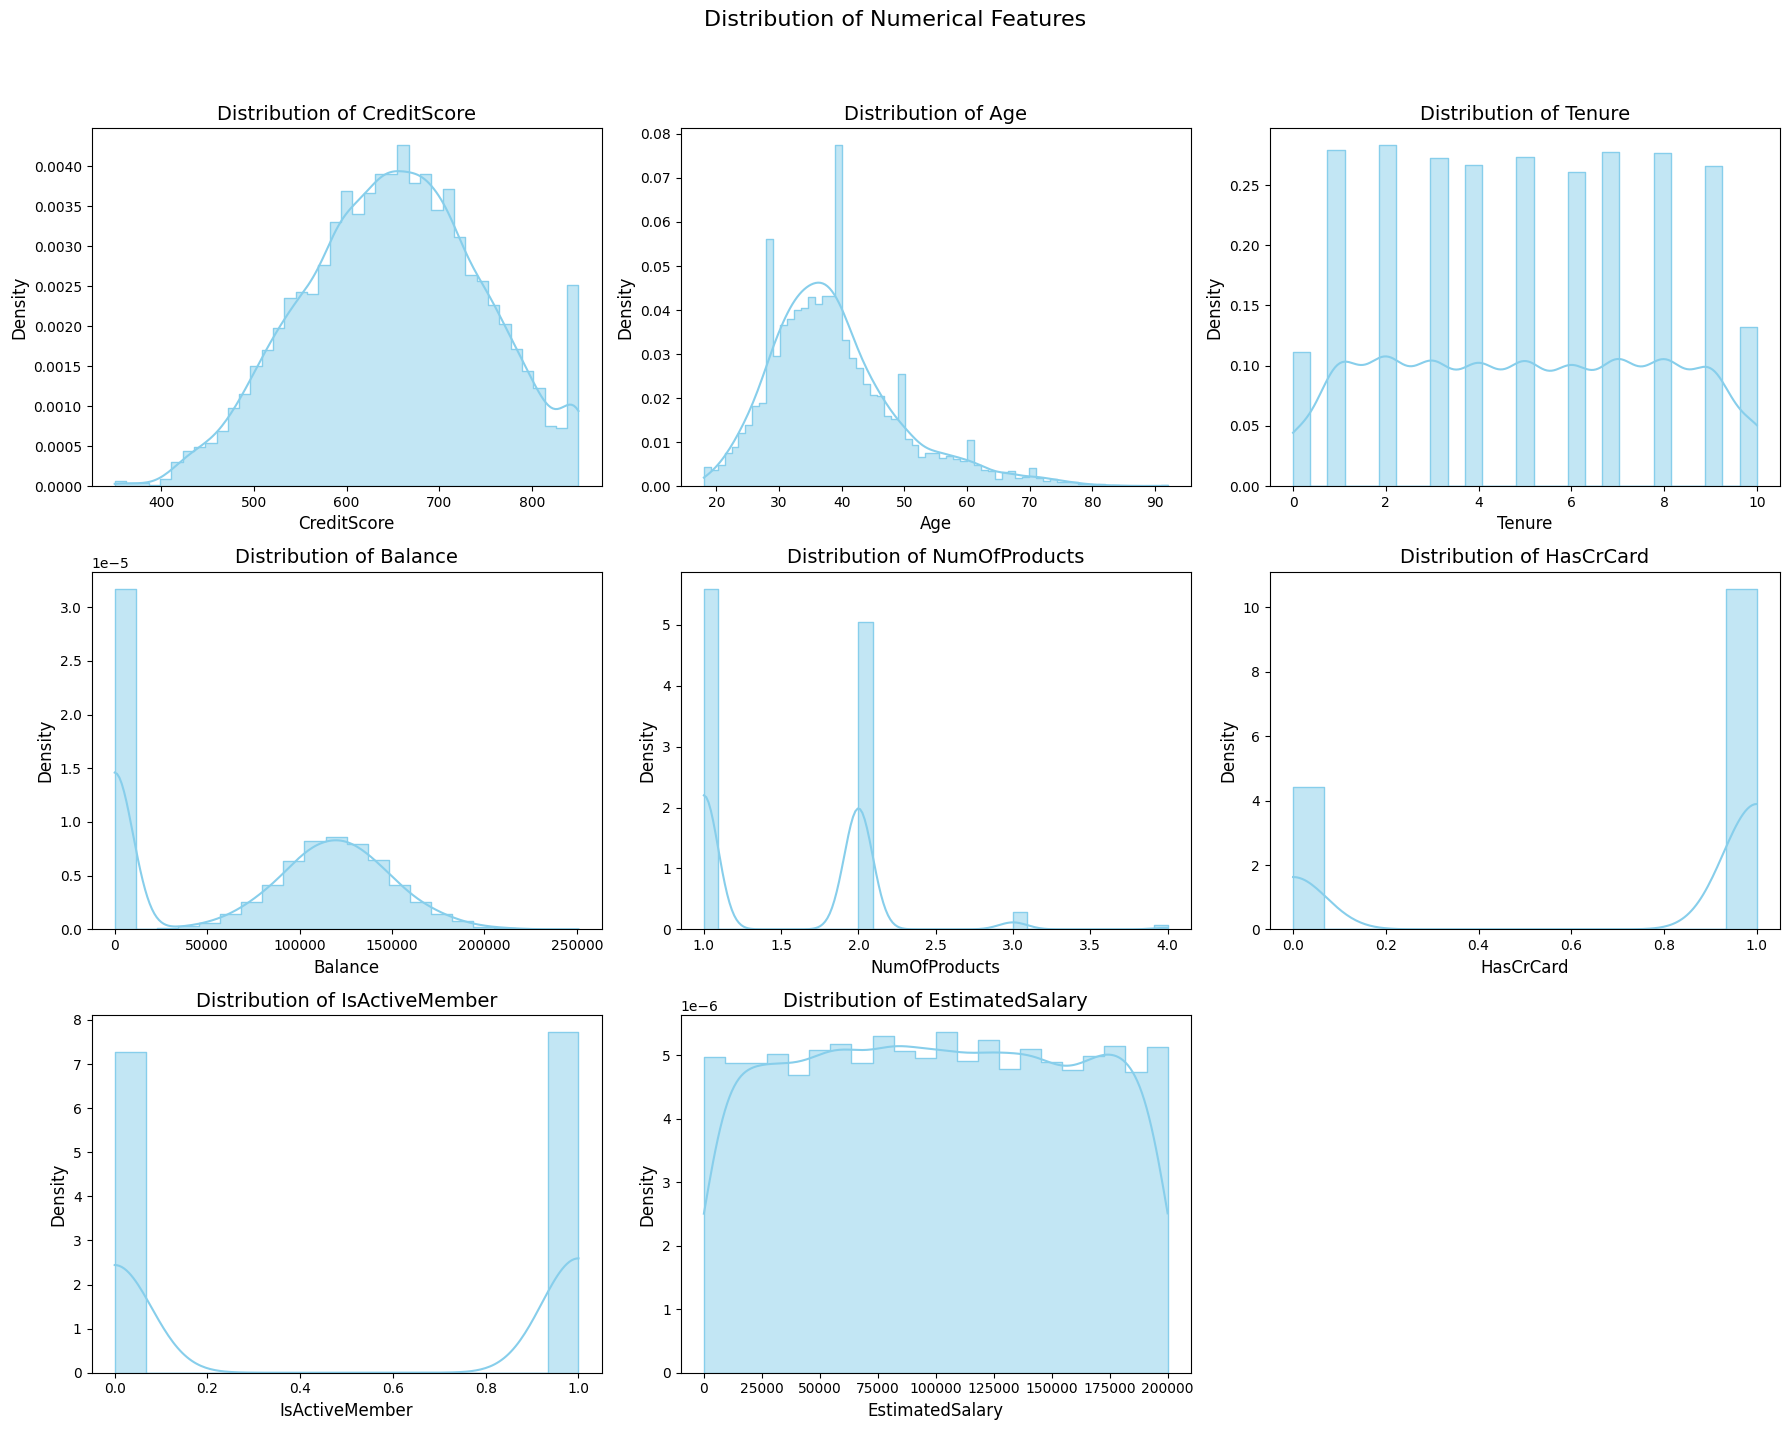

In [14]:
visualize_numerical_distributions(df)

In [15]:
class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[['Geography']]).toarray()
        column_names = ['France', 'Germany', 'Spain']

        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]

        return X

In [16]:
class FeatureLabel(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        label_encoder = LabelEncoder()
        X['Gender'] = label_encoder.fit_transform(X['Gender'])
        return X


In [17]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(['RowNumber', 'CustomerId', 'Surname', 'Geography'], axis=1, errors='ignore')

In [18]:
pipeline = Pipeline([
    ('feature_encoder', FeatureEncoder()),
    ('feature_label', FeatureLabel()),
    ('feature_dropper', FeatureDropper()),
])

In [19]:
train_data = pipeline.fit_transform(df)


In [20]:
train_data.head()


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,0.0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,0.0
3,699,0,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,0.0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0


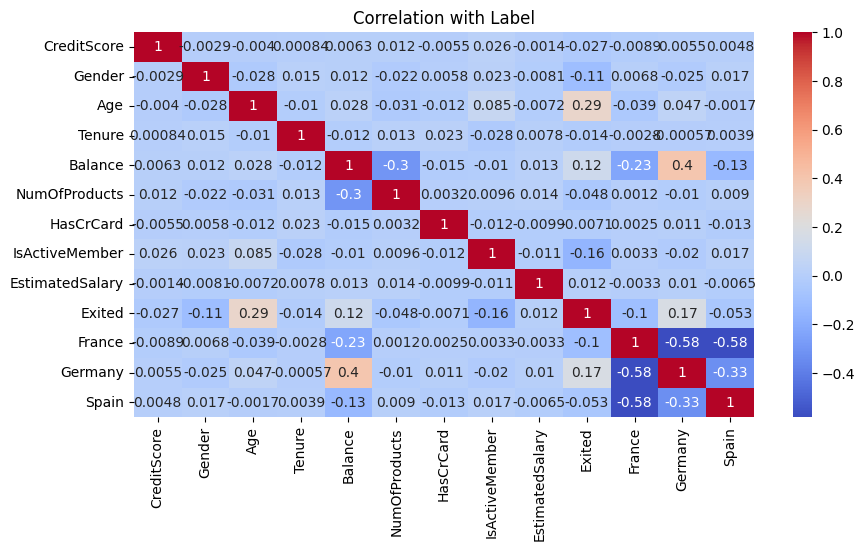

In [21]:
corr_train_data = train_data.corr()

plt.figure(figsize=(10, 5))
sns.heatmap(data=corr_train_data, annot=True, cmap='coolwarm')
plt.title("Correlation with Label")
plt.show()

In [22]:
X = train_data.drop("Exited", axis=1)
y = train_data['Exited']

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
from sklearn.linear_model import LogisticRegression

model_1 = LogisticRegression()
model_1.fit(X_train, y_train)

LogisticRegression()

In [25]:
pred_1 = model_1.predict(X_test)

In [26]:
from sklearn.naive_bayes import BernoulliNB

model_2 = BernoulliNB()
model_2.fit(X_train, y_train)

pred_2 = model_2.predict(X_test)

In [27]:
from sklearn.ensemble import RandomForestClassifier

model_3 = RandomForestClassifier()
model_3.fit(X_train, y_train)

pred_3 = model_3.predict(X_test)

In [28]:
from xgboost import XGBClassifier

model_4 = XGBClassifier()
model_4.fit(X_train, y_train)

pred_4 = model_4.predict(X_test)

In [29]:
from sklearn.metrics import accuracy_score

print("Evaluating the Model:")
print("--" * 10)
print("Logistic Regressoin Model AC:", accuracy_score(y_test, pred_1))
print("BernoulliNB Model AC:", accuracy_score(y_test, pred_2))
print("RandomForestClassifier Model AC:", accuracy_score(y_test, pred_3))
print("XGBClassifier Model AC:", accuracy_score(y_test, pred_4))

Evaluating the Model:
--------------------
Logistic Regressoin Model AC: 0.8005
BernoulliNB Model AC: 0.8
RandomForestClassifier Model AC: 0.862
XGBClassifier Model AC: 0.8625


In [30]:
import pickle

model_name = "b_c_churn_model.pkl"

with open(model_name, 'wb') as file:
    pickle.dump(model_3, file)